MNIST ("Modified National Institute of Standards and Technology") is computer vision dataset released in 1999. It contains data of handwritten images and it is the "de facto" benchmark for classification algorithms. The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

# The data

The data description can be found at [Kaggle](https://www.kaggle.com/c/digit-recognizer/data):

> The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

> Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

> The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

> Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

# Exploration

In [1]:
library(tidyverse)
library(purrrlyr)
library(forcats) # factors munging
library(ggthemes) # visualization
library(scales) # visualization
library(caret) # ML
library(VIM) # missing data
library(Rtsne)
library(viridis)
library(fastknn)

theme_update(plot.title = element_text(hjust = 0.5))

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: colorspace
Loading required package: grid
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and o

In [2]:
train <- read_csv("data/train.csv")
test <- read_csv("data/test.csv")

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


In [3]:
head(train)

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,⋯,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
dim(train)

[1] 42000   785

In [5]:
dim(test)

[1] 28000   784

In [6]:
train <- train %>%
    mutate(label = factor(label))

In [7]:
train <- train %>%
    mutate(intensity = 
           select(., starts_with("pixel")) %>%
               rowMeans()
          ) %>%
    select(intensity, everything())

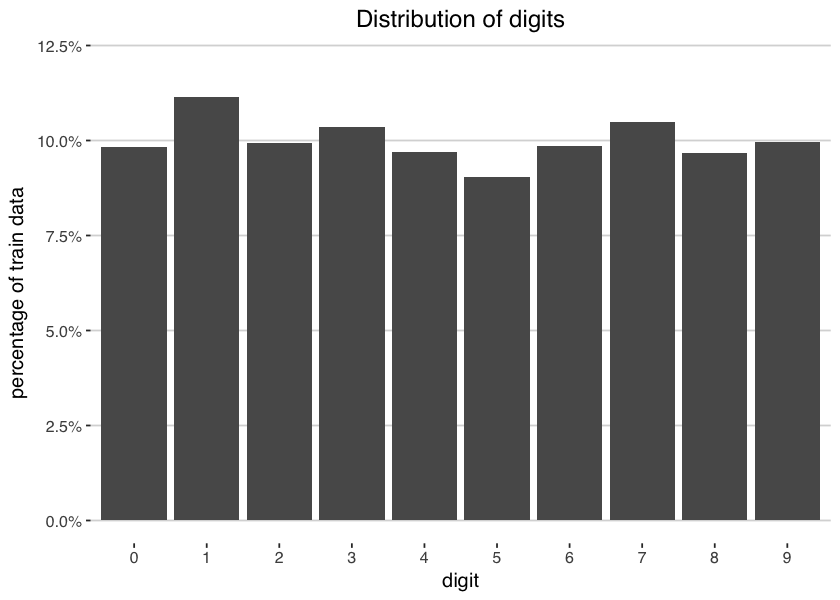

In [120]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(data=train, aes(x=label)) + 
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab("percentage of train data") +
    xlab("digit") +
    ggtitle("Distribution of digits") +
    scale_y_continuous(labels = percent, limits=c(0, 0.12)) +
    theme_hc()

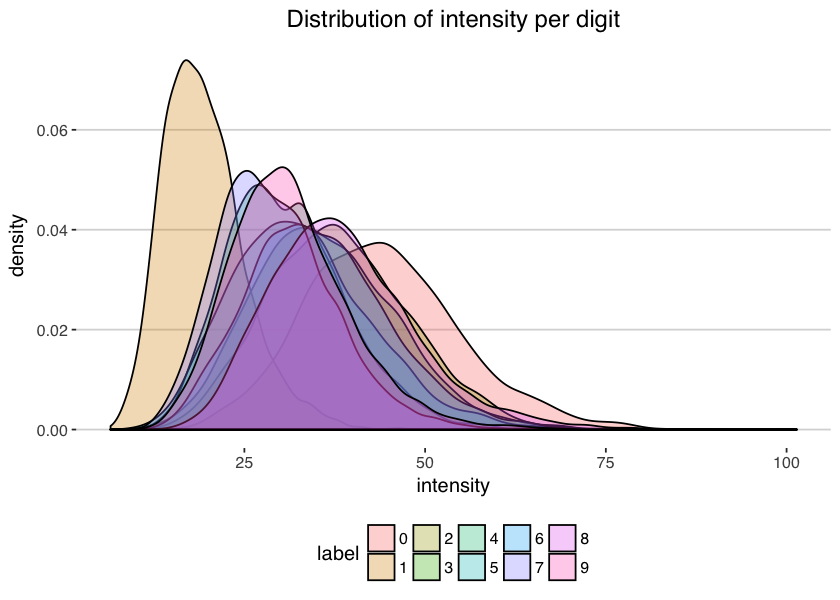

In [117]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(train, aes(x = intensity, y = ..density..)) +
    geom_density(aes(fill = label), alpha = 0.3) +
    ggtitle("Distribution of intensity per digit") +
    theme_hc()

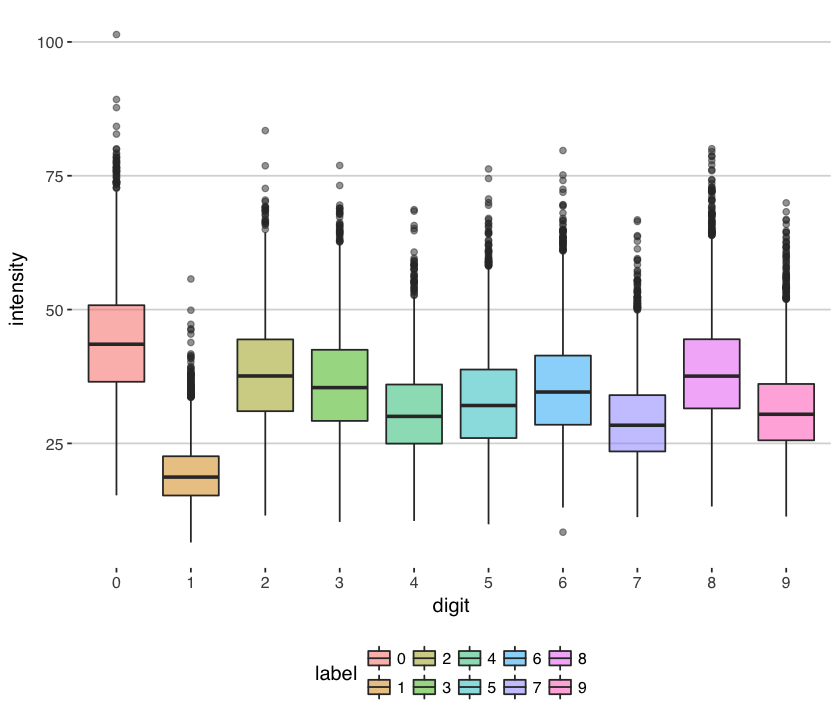

In [111]:
ggplot(train, aes(x = label, y = intensity)) +
    geom_boxplot(aes(fill = label), alpha = 0.5) +
    xlab("digit") +
    theme_hc()

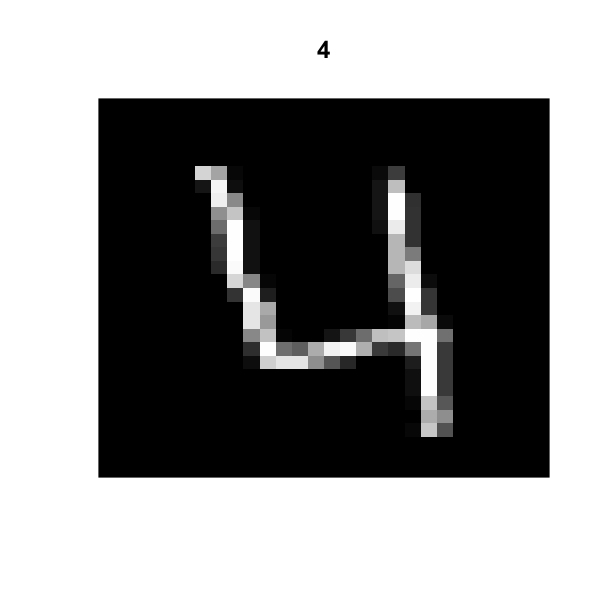

In [11]:
options(repr.plot.width=5, repr.plot.height=5)

flip <- function(matrix) {
      apply(matrix, 2, rev)
}

plot_digit <- function (obs) {
    m <- flip(matrix(rev(as.numeric(obs[-1])), 28, 28))
    image(m, axes = FALSE, col = grey(seq(0, 1, length = 256)))
    title(main = obs$label)
}

train[4, ] %>%
    select(-intensity) %>%
    plot_digit

In [12]:
digit_groups <- train %>%
    group_by(label)

## Mean

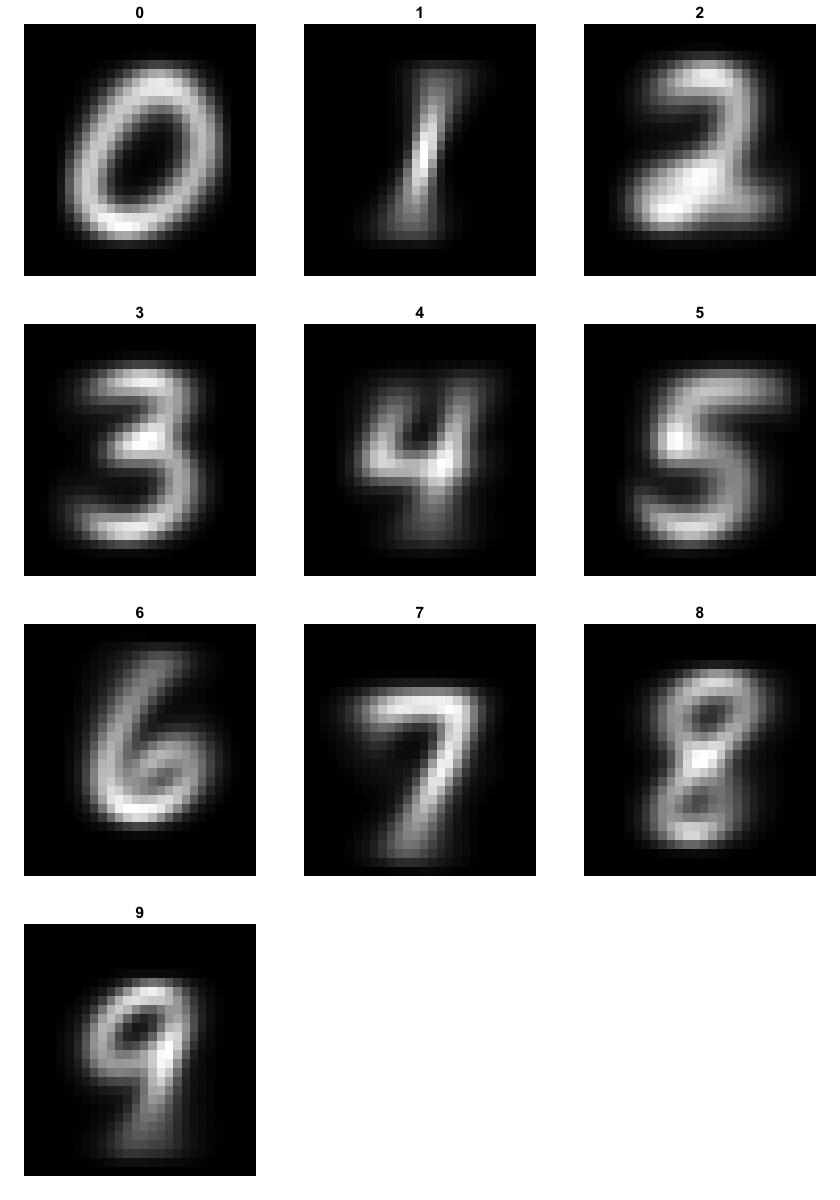

In [13]:
options(repr.plot.width=7, repr.plot.height=10)

par(mfrow=c(4,3), mar=c(1.5, 1.5, 1.5, 1.5))

r <- digit_groups %>%
    summarise_all(funs(mean)) %>%
    select(-intensity) %>%
    by_row(plot_digit)

## Median

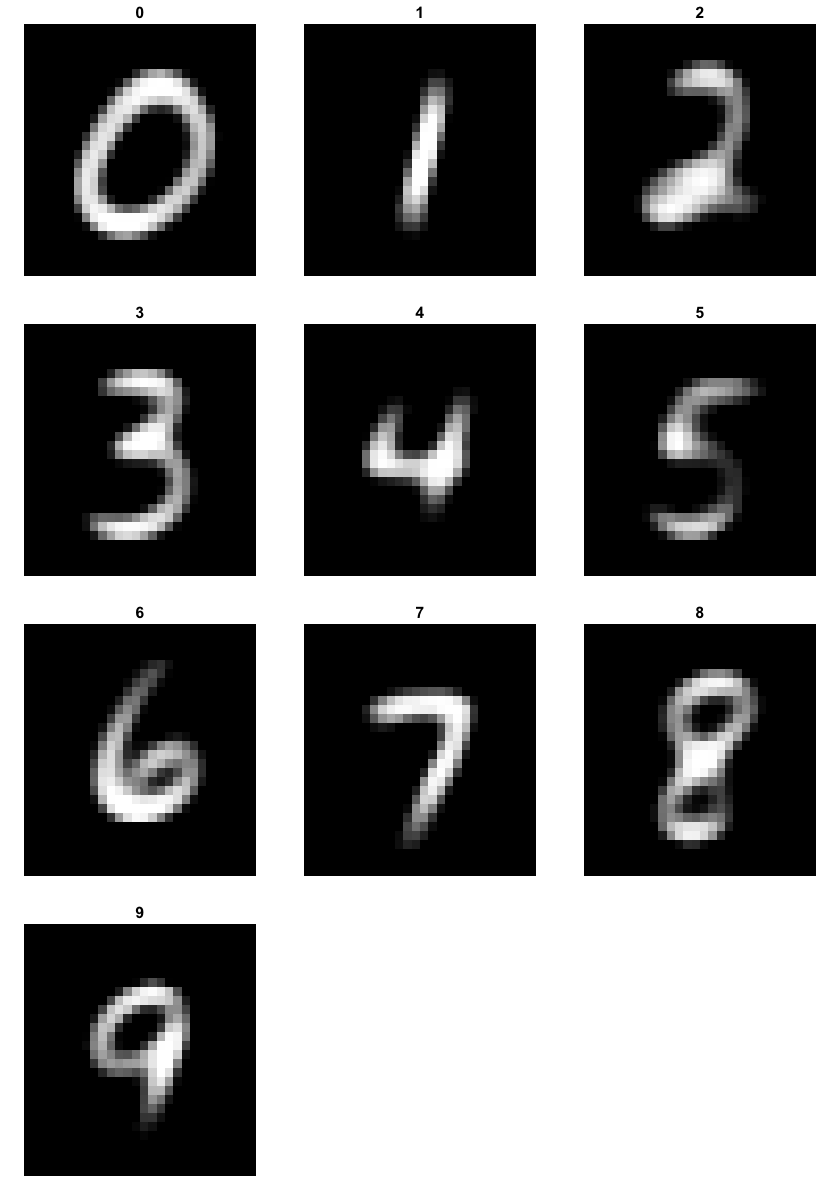

In [14]:
par(mfrow=c(4,3), mar=c(1.5, 1.5, 1.5, 1.5))

r <- digit_groups %>%
    summarise_all(funs(median)) %>%
    select(-intensity) %>%
    by_row(plot_digit)

## Standard deviation

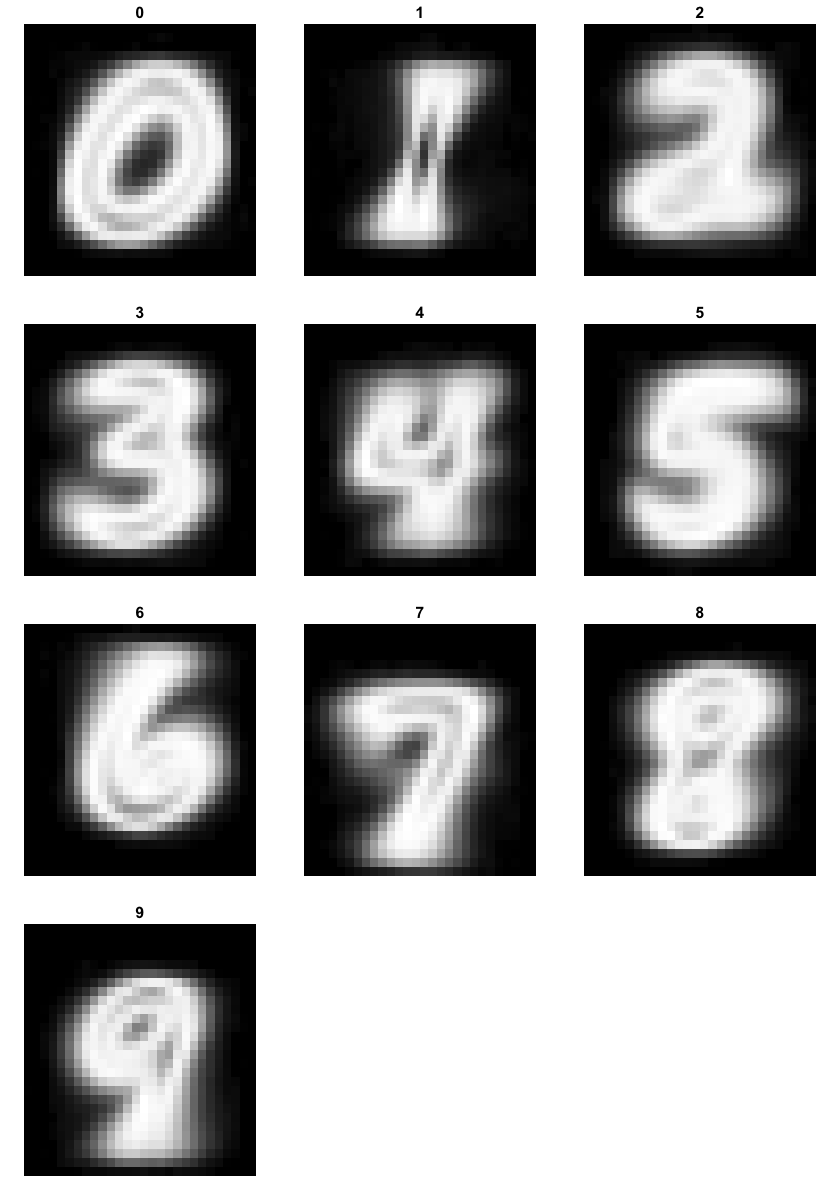

In [15]:
par(mfrow=c(4,3), mar=c(1.5, 1.5, 1.5, 1.5))

r <- digit_groups %>%
    summarise_all(funs(sd)) %>%
    select(-intensity) %>%
    by_row(plot_digit)

## Missing data?

In [16]:
anyNA(train)

[1] FALSE

## Visualizing using t-SNE

t-SNE (t-Distributed Stochastic Neighbour) allows to map high-dimensional data to a 2D or 3D plane. It is most commonly used for visualization purposes. However, the original algorithm is computationally expensive $O(N^4)$ with the number of samples in our data.

We will use Barnes-Hut-SNE algorithm which is an improvement over the standard t-SNE and runs in O(N log N) time. The algorithm is implemented in the [Rtsne](https://cran.r-project.org/web/packages/Rtsne/index.html) package.

In [17]:
nrow(train)

[1] 42000

In [18]:
train_sample <- sample_n(train, 5000)

In [19]:
tsne_data <- as.matrix(select(train_sample, -intensity, -label))
tsne_out <- Rtsne(tsne_data, check_duplicates = FALSE, pca = TRUE, dims = 2)

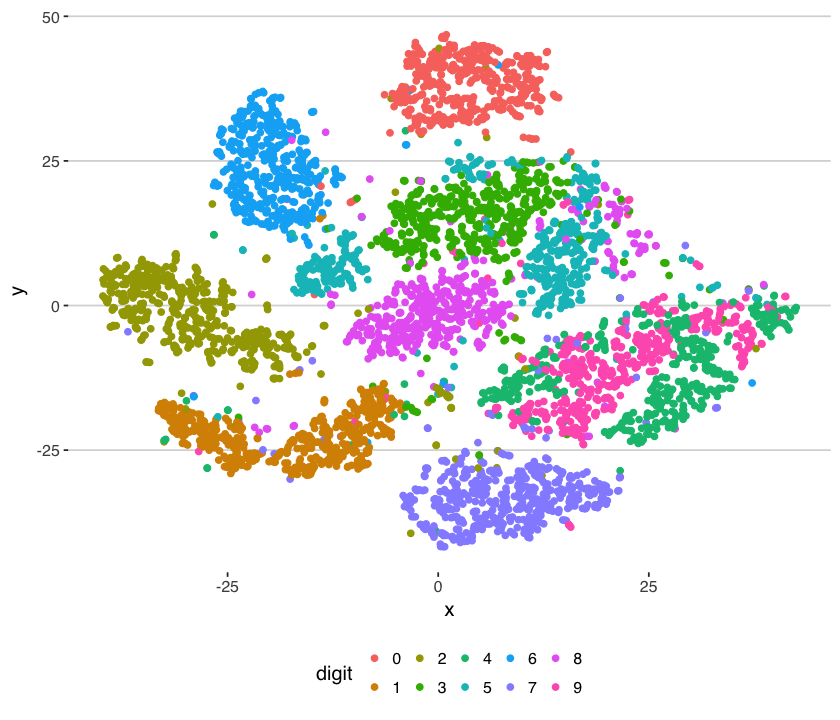

In [107]:
options(repr.plot.width=7, repr.plot.height=6)

plot_data <- tibble(
    x = tsne_out$Y[,1],
    y = tsne_out$Y[,2],
    digit = train_sample$label
)

ggplot(plot_data) + 
    geom_point(aes(x=x, y=y, color=digit)) +
    theme_hc()

# Building a model

In [21]:
train_index <- createDataPartition(train$label, p=0.8, list=FALSE)
cv_train <- train[train_index, ]
cv_validation <- train[-train_index, ]

In [22]:
train_data <- select(cv_train, -label, -intensity)
train_labels <- cv_train$label

validation_data <- select(cv_validation, -label, -intensity)
validation_labels <- cv_validation$label

In [38]:
knn_model <- fastknn(
    as.matrix(train_data), 
    train_labels,
    as.matrix(validation_data), 
    k=10,
    method = "dist"
)

In [49]:
confusion_matrix <- caret::confusionMatrix(
    table(predicted=knn_model$class, actual=validation_labels)
)

In [50]:
confusion_matrix

Confusion Matrix and Statistics

         actual
predicted   0   1   2   3   4   5   6   7   8   9
        0 819   0   5   0   1   4   3   0   1   3
        1   1 928  16   4  12   1   3   7  12   1
        2   1   2 792   4   0   0   1   0   3   1
        3   0   0   1 843   0   7   0   0  13   6
        4   0   2   0   0 771   0   1   1   2  11
        5   1   0   1   5   0 729   0   0  13   2
        6   3   1   3   1   6   8 819   0   1   0
        7   0   2  13   4   3   2   0 862   5  17
        8   0   1   4   4   0   0   0   0 750   1
        9   1   0   0   5  21   8   0  10  12 795

Overall Statistics
                                          
               Accuracy : 0.9657          
                 95% CI : (0.9616, 0.9695)
    No Information Rate : 0.1115          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9619          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

              

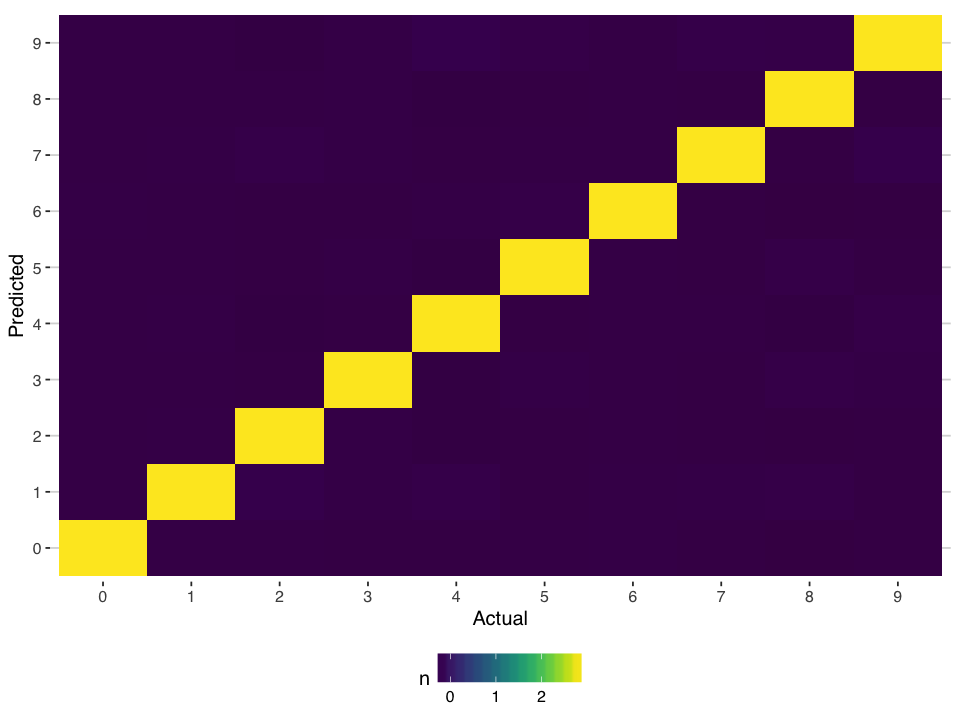

In [123]:
options(repr.plot.width=8, repr.plot.height=6)

ggplot(as.tibble(scale(confusion_matrix$table))) + 
    geom_tile(aes(x=actual, y=predicted, fill=n)) +
    scale_x_discrete(name="Actual") + 
    scale_y_discrete(name="Predicted") +
    scale_color_viridis(discrete=TRUE) +
    scale_fill_viridis(option="viridis") +
    theme_hc()